In [1]:
import os
import torch
from torch.utils.data import random_split, dataloader
from torchvision import datasets
from torchvision import transforms
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

from kmnist_model import SimpleModel, BatchModel, DropoutModel, LeNetModel, ConvNetModel
from funcs import train, predict

In [2]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

# Завантажую дані та ділю на train/val/test

In [4]:
train_data = datasets.KMNIST(
    root='data',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    )

In [5]:
test_data = datasets.KMNIST(
    root='data',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
    )

In [6]:
train_size = int(0.85 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

In [7]:
image, label = train_data[0]
print(f"Data shape: {image.shape}")
print(f"Label: {label}")
print('Train:', len(train_data))
print('Valid:', len(valid_data))
print('Test:', len(test_data.data), len(test_data.targets))

Data shape: torch.Size([1, 28, 28])
Label: 7
Train: 51000
Valid: 9000
Test: 10000 10000


In [8]:
class_names = train_data.dataset.classes
print('Class names:', class_names)

Class names: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


Image shape: torch.Size([1, 28, 28])


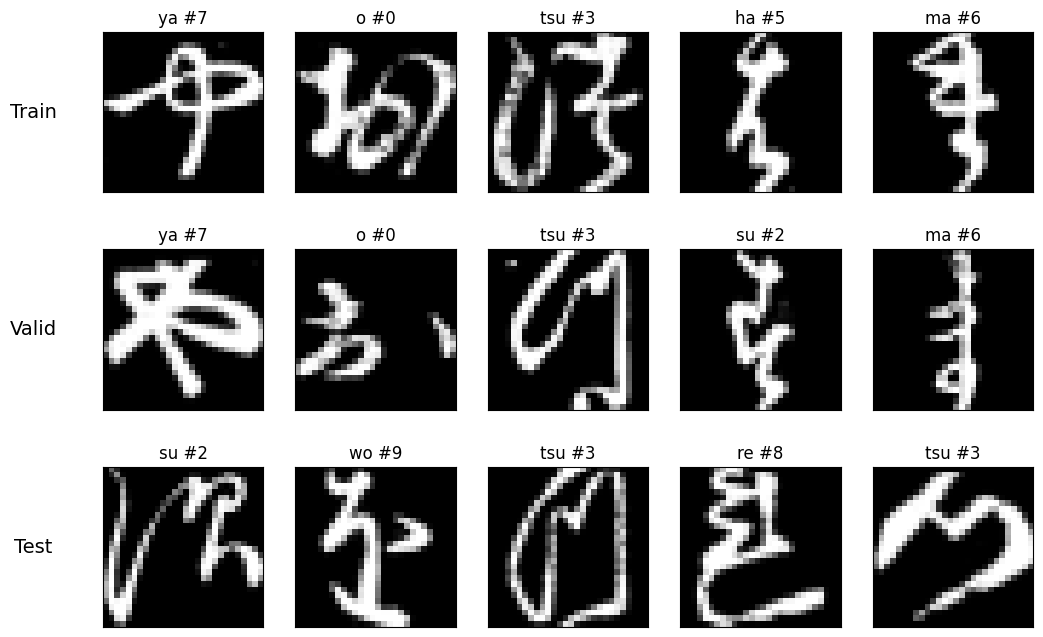

In [9]:
image, label = train_data[0]
print('Image shape:', image.shape)

fig, axs = plt.subplots(3, 5, figsize=(12, 8))
row_names = ['Train', 'Valid', 'Test']

for i, data in enumerate([train_data, valid_data, test_data]):
    for j in range(5):
        image, label = data[j]
        axs[i, j].imshow(image.squeeze(), cmap='gray')
        axs[i, j].set_title(f'{class_names[label]} #{label}')
        # прибере осі, але залишить підписи
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axs[i, 0].set_ylabel(row_names[i], fontsize=14, rotation=0, labelpad=50, va='center')
plt.show()

# Роблю розбиття на батчі

In [10]:
BATCH_SIZE = 32
train_dataloader = dataloader.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
)

valid_dataloader = dataloader.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count(),
    drop_last=True,
)

print(f"Length of Train dataloader: {len(train_dataloader)}")
print(f"Length of Valid dataloader: {len(valid_dataloader)}")

Length of Train dataloader: 1593
Length of Valid dataloader: 281


Train image batch shape: torch.Size([32, 1, 28, 28])
Train label batch shape: torch.Size([32])


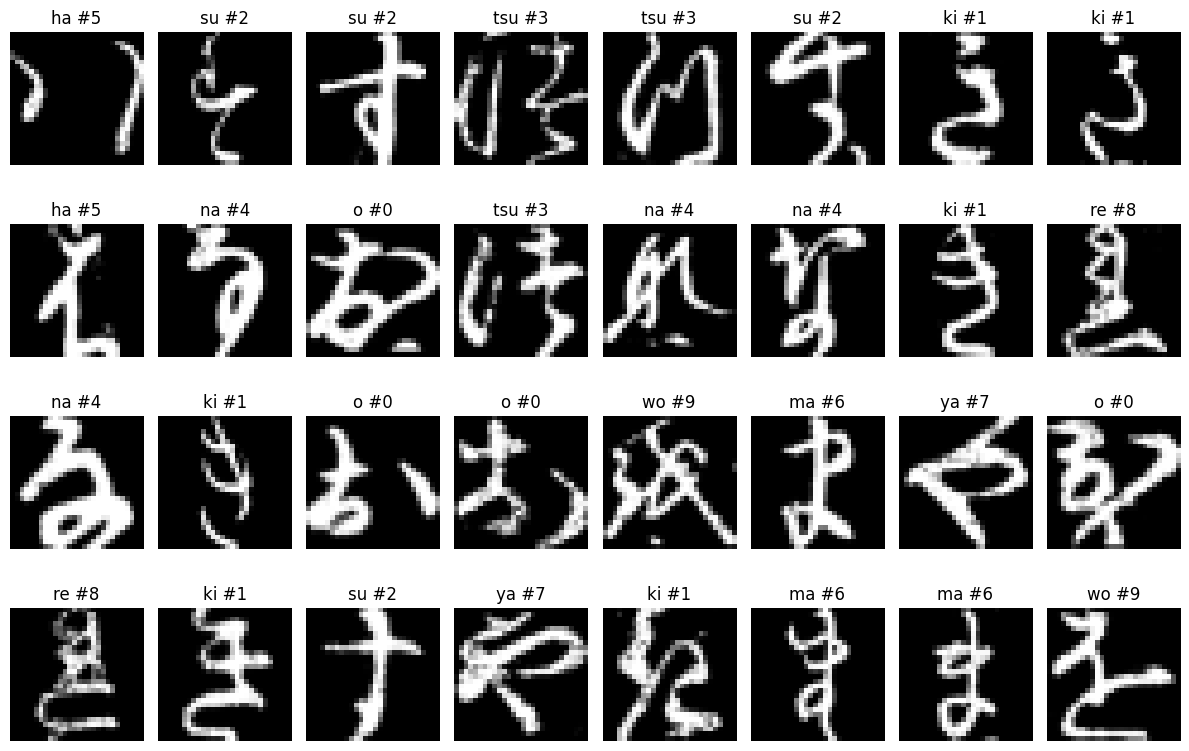

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print('Train image batch shape:', train_features_batch.shape)
print('Train label batch shape:', train_labels_batch.shape)

count = train_features_batch.shape[0]
rows = 4
columns = count // rows

fig, axs = plt.subplots(rows, columns, figsize=(12, 8))
for idx in range(count):
    row = idx // columns
    col = idx % columns
    axs[row, col].imshow(train_features_batch[idx].squeeze(), cmap='gray')
    axs[row, col].set_title(f'{class_names[train_labels_batch[idx]]} #{train_labels_batch[idx]}')
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

# Створюю згорточну модель та треную (файл kmnist_model.py, funcs.py)

## Simple model

In [12]:
simple_model = SimpleModel(input_channels=1, hidden_channels=10, output_shape=len(class_names)).to(device)
print(simple_model)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.005)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

SimpleModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.SimpleModel'> Train loss: 1.2872, Train accuracy: 0.5728


Training:  10%|█         | 1/10 [01:17<11:34, 77.16s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.9959, Valid accuracy: 0.6862
Epoch 2/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.9018, Train accuracy: 0.7048


Training:  20%|██        | 2/10 [02:32<10:10, 76.25s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.8151, Valid accuracy: 0.7316
Epoch 3/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.8044, Train accuracy: 0.7397


Training:  30%|███       | 3/10 [03:50<08:59, 77.08s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.8084, Valid accuracy: 0.7457
Epoch 4/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.7339, Train accuracy: 0.7594


Training:  40%|████      | 4/10 [05:11<07:50, 78.46s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6797, Valid accuracy: 0.7778
Epoch 5/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6970, Train accuracy: 0.7738


Training:  50%|█████     | 5/10 [06:22<06:18, 75.69s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6889, Valid accuracy: 0.7775
Epoch 6/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6766, Train accuracy: 0.7794


Training:  60%|██████    | 6/10 [07:30<04:52, 73.04s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6859, Valid accuracy: 0.7753
Epoch 7/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6531, Train accuracy: 0.7878


Training:  70%|███████   | 7/10 [08:37<03:33, 71.21s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6303, Valid accuracy: 0.7966
Epoch 8/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6368, Train accuracy: 0.7929


Training:  80%|████████  | 8/10 [09:45<02:20, 70.14s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6576, Valid accuracy: 0.7891
Epoch 9/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6202, Train accuracy: 0.7977


Training:  90%|█████████ | 9/10 [10:53<01:09, 69.49s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6340, Valid accuracy: 0.7953
Epoch 10/10
<class 'kmnist_model.SimpleModel'> Train loss: 0.6053, Train accuracy: 0.8020


Training: 100%|██████████| 10/10 [12:00<00:00, 72.02s/it]

<class 'kmnist_model.SimpleModel'> Valid loss: 0.6186, Valid accuracy: 0.8014
Total training time: 720.25 seconds


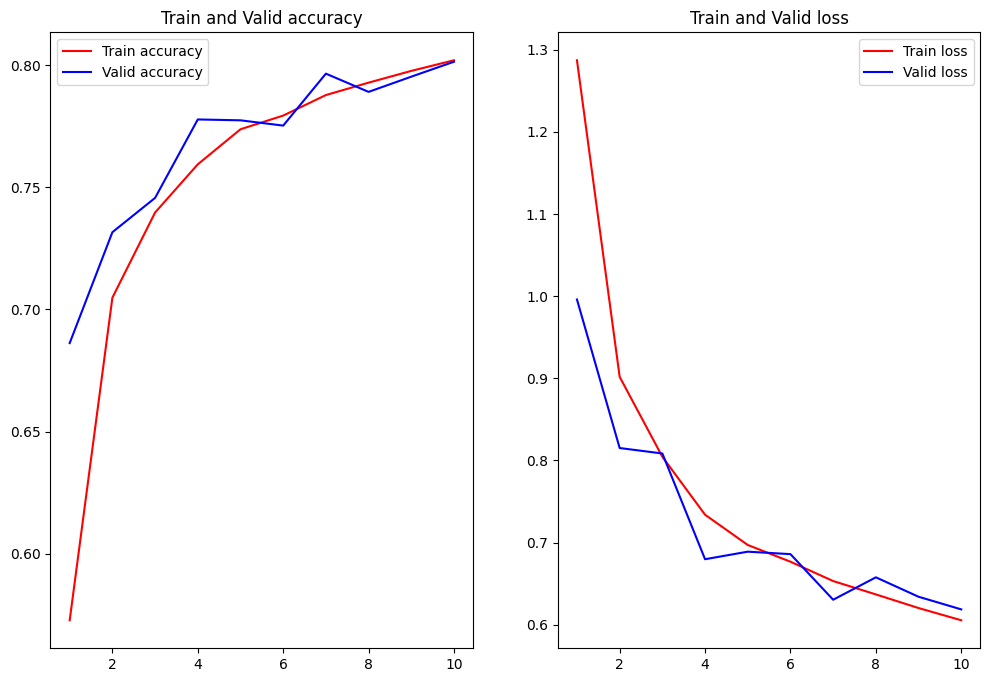

([1.2872315645217896,
  0.9017677307128906,
  0.8044154047966003,
  0.7338556051254272,
  0.6970134973526001,
  0.6766360998153687,
  0.6530865430831909,
  0.6368299126625061,
  0.6202195882797241,
  0.6053345203399658],
 [0.5727601647377014,
  0.7048388123512268,
  0.7397056221961975,
  0.7594331502914429,
  0.7737924456596375,
  0.7793893814086914,
  0.7877940535545349,
  0.7928735017776489,
  0.7976874113082886,
  0.8020356893539429],
 [0.995944619178772,
  0.8150707483291626,
  0.808432400226593,
  0.6796776652336121,
  0.6888700127601624,
  0.6858676075935364,
  0.630340039730072,
  0.6576321721076965,
  0.633986234664917,
  0.6185975074768066],
 [0.6862423419952393,
  0.7316474318504333,
  0.7456883788108826,
  0.7778100371360779,
  0.7774544358253479,
  0.7752914428710938,
  0.7965613603591919,
  0.7890974879264832,
  0.7953236699104309,
  0.8014426827430725])

In [13]:
train(simple_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## Batch model

In [14]:
batch_model = BatchModel(input_channels=1, hidden_channels=10, output_shape=len(class_names)).to(device)
print(batch_model)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(batch_model.parameters(), lr=0.005)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

BatchModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Fl

In [ ]:
train(batch_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
<class 'kmnist_model.BatchModel'> Train loss: 0.8686, Train accuracy: 0.7416


## Dropout model

In [ ]:
dropout_model = DropoutModel(input_channels=1, hidden_channels=10, output_shape=len(class_names)).to(device)
print(dropout_model)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=0.01)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

NameError: name 'DropoutModel' is not defined

Training: 0it [00:00, ?it/s]

Total training time: 0.00 seconds


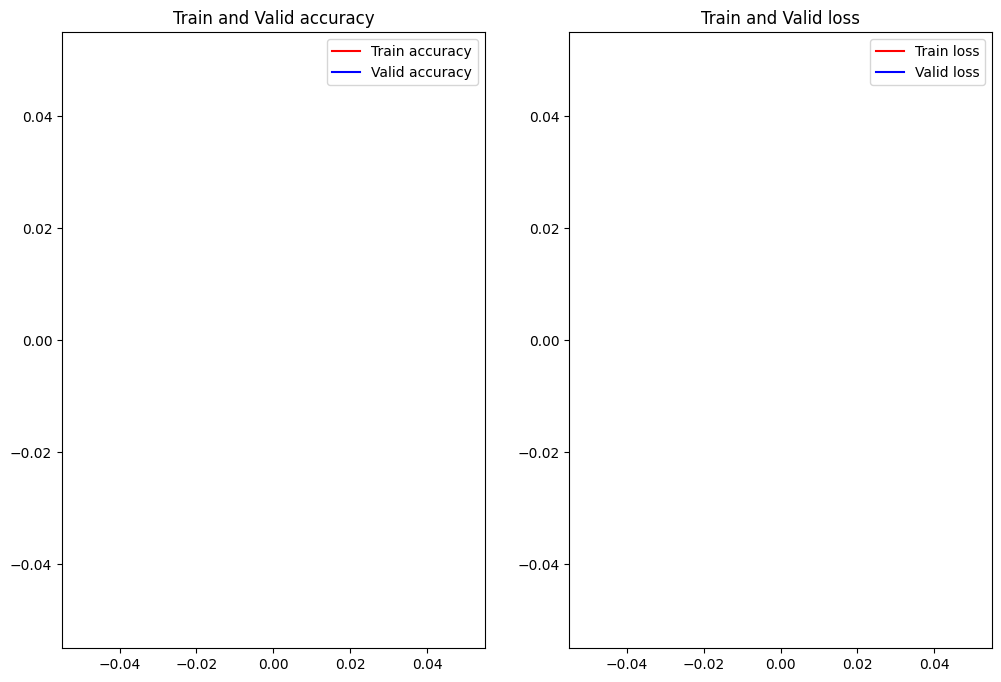

In [ ]:
train(dropout_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## LeNet model

In [ ]:
lenet_model = LeNetModel(input_channels=1, output_shape=len(class_names)).to(device)
print(lenet_model)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=0.005)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 10

LeNetModel(
  (convolutional_block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (fully_connected_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)


Training: 0it [00:00, ?it/s]

Total training time: 0.00 seconds


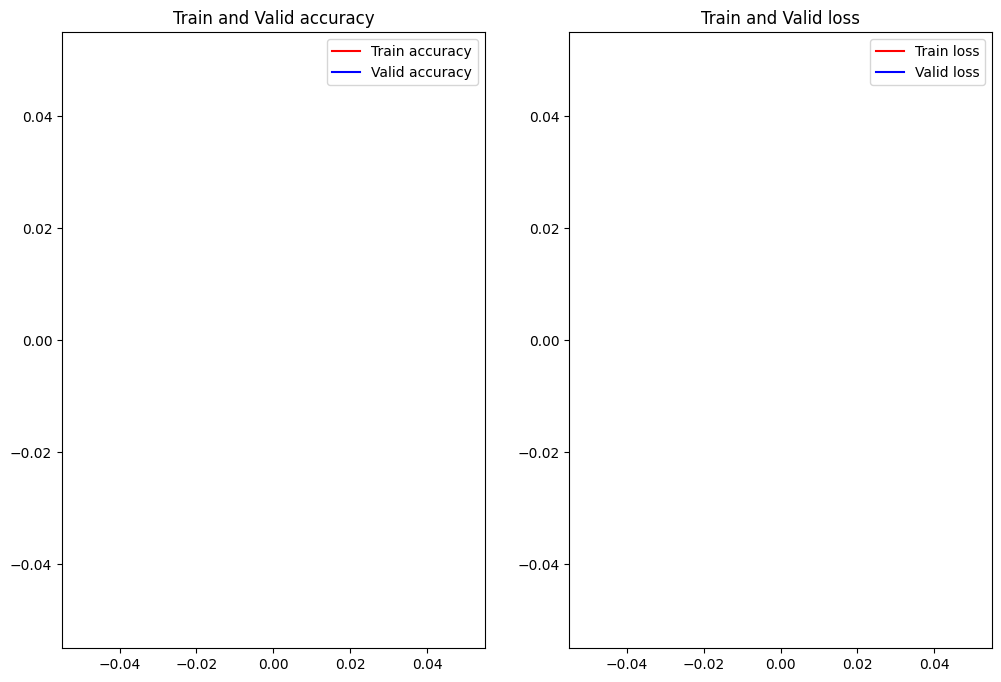

In [ ]:
train(lenet_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

## ConvNet VGG16 (Модификований)

In [ ]:
convnet_model = ConvNetModel(input_channels=1, output_shape=len(class_names)).to(device)
print(convnet_model)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet_model.parameters(), lr=0.001)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
epochs = 5

ConvNetModel(
  (convolutional_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolutional_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolutio

In [ ]:
train(convnet_model, train_dataloader, valid_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=epochs)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
<class 'kmnist_model.ConvNetModel'> Train loss: 0.1763, Train accuracy: 0.9403


Training:  20%|██        | 1/5 [03:10<12:43, 190.81s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0787, Valid accuracy: 0.9723
Epoch 2/5
<class 'kmnist_model.ConvNetModel'> Train loss: 0.0599, Train accuracy: 0.9786


Training:  40%|████      | 2/5 [06:21<09:33, 191.02s/it]

<class 'kmnist_model.ConvNetModel'> Valid loss: 0.0470, Valid accuracy: 0.9840
Epoch 3/5


In [ ]:
raise(Exception('Stop here!'))

# Роблю предікти та будую графіки

In [ ]:
pred_probs = []
convnet_model.eval()
with torch.inference_mode():
    for X, y in test_data:
        X = torch.unsqueeze(X, dim=0).to(device) 
        pred_logit = convnet_model(X)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        predicted_class = pred_prob.argmax().item()
        pred_probs.append(predicted_class)
print(pred_probs[:10])
print(test_data.targets[:10])


[7, 3, 3, 5, 1, 7, 1, 7, 7, 1]
tensor([2, 9, 3, 8, 3, 3, 8, 3, 2, 5])


In [ ]:
true_values = test_data.targets
pred_values = []
for X, y in test_data:
    pred = predict(X, lenet_model, device).cpu().unsqueeze(0)
    pred_values.append(pred)
pred_values = torch.cat(pred_values)
compar_list = [a == b for a, b in zip(true_values, pred_values)]
print(f'{sum(compar_list)}/{len(compar_list)}')

1001/10000


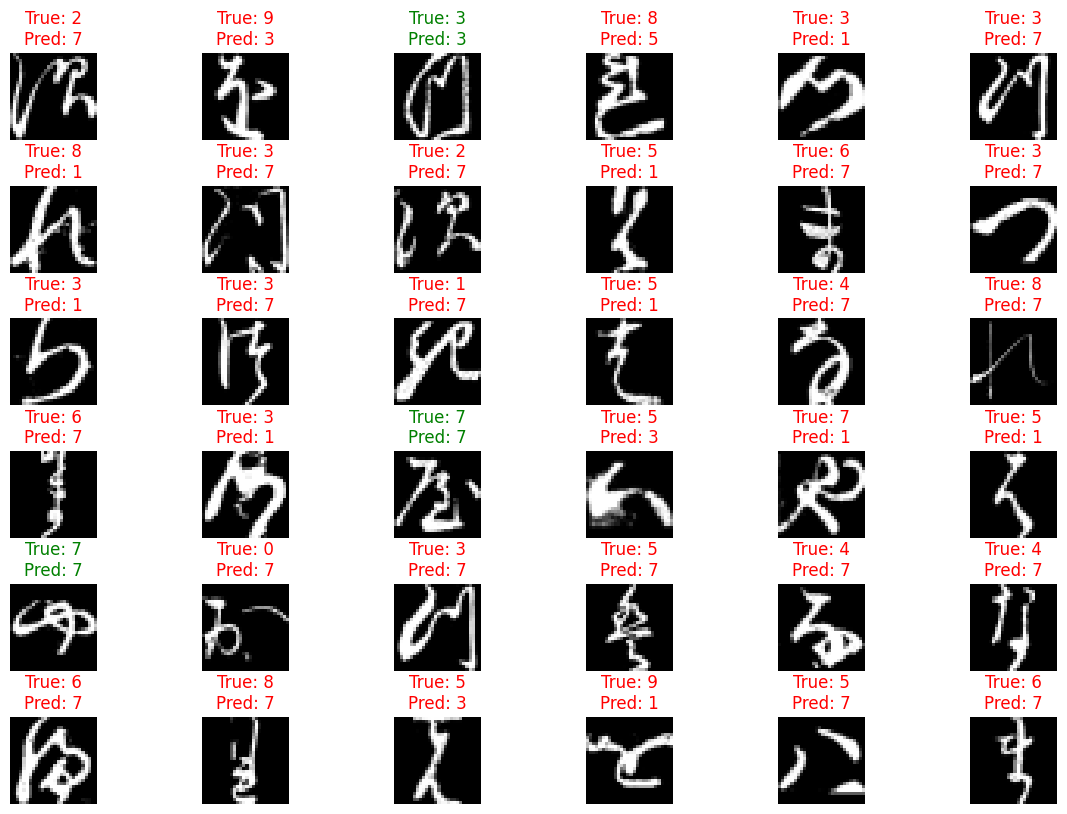

In [ ]:
rows = 6
columns = 6

fig, axs = plt.subplots(rows, columns, figsize=(12, 8))
for i in range(rows):
    for j in range(columns):
        idx = i * rows + j
        axs[i, j].imshow(test_data.data[idx].squeeze(), cmap='gray')
        text = f'True: {test_data.targets[idx]}\nPred: {pred_values[idx]}'
        if true_values[idx] == pred_values[idx]:
            axs[i, j].set_title(text, color='green')
        else:
            axs[i, j].set_title(text, color='red')
        axs[i, j].axis('off')   
plt.tight_layout(pad=0.2)

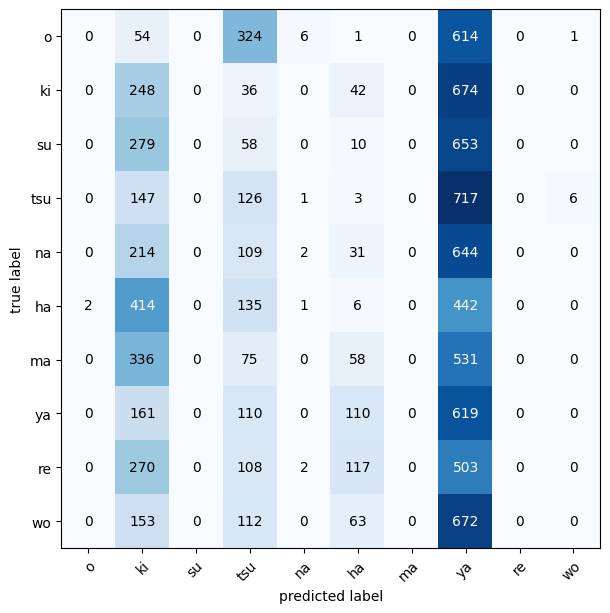

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=pred_values,
                         target=true_values)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);